# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,2)\times(0,3)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$
\psi(t,x,z)=
\left\{
\begin{array}{ll}
\begin{array}{l} 
-2+2.2 \frac{t}{\Delta t_D}, \text{ on } \Gamma_{D_1}, t\leq\Delta t_D\\
0.2, \text{ on } \Gamma_{D_1}, t>\Delta t_D\\
1-z, \text{ on } \Gamma_{D_2}
\end{array}
\end{array}
\right., \qquad \nu \cdot q = 0 \text{ on } \Gamma_N \qquad \psi(0,x,z) = 1-z \text{ on } \Omega$$
and
$$
\Gamma_{D_1} = \left\{ (x,z) \in \partial \Omega \:|\: x \in [0,1] \wedge z=3  \right\},\\
\Gamma_{D_2} = \left\{ (x,z) \in \partial \Omega \:|\: x = 2 \wedge z \in [0,1]  \right\},\\
\Gamma_{D} = \Gamma_{D_1} \cup \Gamma_{D_2},\\
\Gamma_{N} = \partial \Omega \setminus \Gamma_D
$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
import sympy as sp

import porepy as pp
import pygeon as pg

from math import ceil, floor, log10, exp

import matplotlib.pyplot as plt

In [2]:
K = 50
N = 10

eps_psi_abs = 1e-5
eps_psi_rel = 1e-5

domain_tolerance = 1 / (10 * N)
beta_q   = 0
beta_psi = 0

output_directory = 'output_evolutionary'

In [3]:
rho = 1000
g = pp.GRAVITY_ACCELERATION

In [4]:
theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

In [5]:
dt_D = 1/16
dt   = 1/48
T    = 3/16

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [6]:
def theta(psi):
    res = np.ones_like(psi) * theta_s

    mask = psi <= 0
    res[mask] = theta_r + (theta_s  - theta_r) * 1 / np.power(1 + np.power(-alpha * psi[mask], n), (n-1)/n)

    # print(res[mask])

    return res

In [7]:
def dtheta_dpsi(psi, order=1):
    if order == 0:
        return theta(psi)


    psi_var = sp.Symbol('psi', negative=True)
    diff = sp.diff( theta_r + (theta_s  - theta_r) * (1 / (1+(-alpha * psi_var) ** n)) ** ((n-1)/n) , psi_var, order )
    
    res = np.zeros_like(psi)

    mask = psi <= 0
    res[mask] = np.array( list( diff.subs(psi_var, val).evalf() for val in psi[mask] ) )

    return res

In [8]:
def conductivity_coeff(psi):
    coeff = np.ones_like(psi) * K_s

    mask = psi <= 0
    th = theta(psi[mask])
    coeff[mask] = K_s * np.power(th, (1/2)) * np.power( 1 - np.power( 1 - np.power(th , ( n / (n-1) ) ), ((n-1)/n)), 2)

    return coeff

In [9]:
def dconductivity_coeff_dpsi(psi, order=1):
    if order == 0:
        return conductivity_coeff(psi)
    
    coeff = np.zeros_like(psi)

    mask = psi <= 0

    psi_var = sp.Symbol('psi', negative=True)
    exp = theta_r + (theta_s  - theta_r) * (1 / (1+(-alpha * psi_var) ** n)) ** ((n-1)/n)

    diff = sp.diff( K_s * (exp ** (1/2)) * ( 1 - ( 1 - ( exp ** ( n / (n-1) ) ) ) ** ((n-1)/n) ) ** 2, psi_var, order)

    coeff[mask] = np.array(list(diff.subs(psi_var, val).evalf() for val in psi[mask]))

    return coeff

In [10]:
def dconductivity_tensor_dpsi(psi, order=1):
    return pp.SecondOrderTensor(dconductivity_coeff_dpsi(psi, order))

In [11]:
def conductivity_tensor(psi):
    return dconductivity_tensor_dpsi(psi, 0)

In [12]:
def quick_plot(theta_der = 0, cond_der = 0):
    psi_val = np.linspace(-2, 1, 100)
    theta_val = dtheta_dpsi(psi_val, theta_der)
    kappa_val = 1 / dconductivity_coeff_dpsi(psi_val, cond_der)

    theta_max = theta_s
    theta_min = theta_r

    kappa_max = 1 / dconductivity_coeff_dpsi(np.array([-1e10]), cond_der)
    kappa_min = 1 / K_s

    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(psi_val, theta_val)
    ax1.plot(psi_val, theta_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax1.plot(
        psi_val,
        theta_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax1.set_title("theta")

    ax2.plot(psi_val, kappa_val)
    ax2.set_title("kappa^(-1)")

    plt.show()

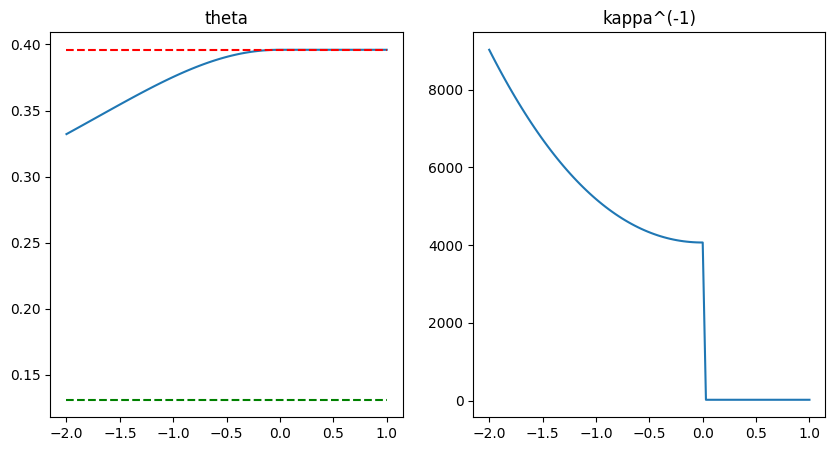

In [13]:
quick_plot(0, 0)

### Domain preparation

In [14]:
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [15]:
key = "flow"

bc_value = []
bc_essential = []
initial_pressure = []

gravity = []

RT0 = pg.RT0(key)
P0  = pg.PwConstants(key)

In [16]:
def g_func(x): 
    return np.array([0, -1, -1])

In [17]:
def initial_pressure_func(x): 
    return 1-x[1]

In [18]:
for subdomain, data in mdg.subdomains(return_data=True):
    g_proj = RT0.interpolate(subdomain, g_func)
    gravity.append(RT0.assemble_mass_matrix(subdomain) @ g_proj)
    
    initial_pressure.append(P0.interpolate(subdomain, initial_pressure_func))
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    boundary_faces_indexes = subdomain.get_boundary_faces()

    gamma_d1 = np.logical_and(subdomain.face_centers[0, :] > 0-domain_tolerance, np.logical_and(subdomain.face_centers[0, :] < 1+domain_tolerance, subdomain.face_centers[1, :] > 3-domain_tolerance))
    gamma_d2 = np.logical_and(subdomain.face_centers[0, :] > 2-domain_tolerance, np.logical_and(subdomain.face_centers[1, :] > 0-domain_tolerance, subdomain.face_centers[1, :] < 1+domain_tolerance))

    gamma_d  = np.logical_or(gamma_d1, gamma_d2)
    
    gamma_n  = gamma_d.copy()
    gamma_n[boundary_faces_indexes] = np.logical_not(gamma_n[boundary_faces_indexes])
    
    def bc_gamma_d(x, t):
        if   x[0] > 2-domain_tolerance and x[1] > 0-domain_tolerance and x[1] < 1+domain_tolerance:
            res =  1 - x[1]
        elif x[1] > 3-domain_tolerance and x[0] > 0-domain_tolerance and x[0] < 1+domain_tolerance:
            res = min( 0.2, -2 + 2.2 * t / dt_D )
        else:
            res = 0

        #print(t, x, res)
        
        return res

    bc_value.append(lambda t: - RT0.assemble_nat_bc(subdomain, lambda x: bc_gamma_d(x,t), gamma_d))

    essential_pressure_dofs = np.zeros(P0.ndof(subdomain), dtype=bool)
    bc_essential.append(np.hstack((gamma_n, essential_pressure_dofs)))

In [19]:
gamma_d.sum(), gamma_n.sum(), len(subdomain.get_boundary_faces())

(20, 80, 100)

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q^{n+1}} + \nabla \psi^{n+1} = -\nabla z\\
\frac{\theta (\psi^{n+1}) - \theta (\psi^{n})}{\Delta t} + \nabla \cdot {q^{n+1}} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$


$$
Netwon \qquad
\left\{
\begin{array}{ll}
\begin{array}{l} 
M^{n+1}_k q_{k+1}^{n+1} + [B^T + C(\psi_k^{n+1}, q_ {k}^{n+1})] \psi^{n+1}_{k+1} = G^{n+1} + C(\psi_k^{n+1}, q_ {k}^{n+1}) \psi_k^{n+1} + BC^{n+1}\\
\frac{1}{\Delta t} D(\psi_{k}^{n+1}) \psi_{k+1}^{n+1} -B q_{k+1}^{n+1} = \frac{\Theta^n - \Theta^{n+1}_k}{\Delta t} + \frac{1}{\Delta t} D(\psi_{k}^{n+1}) \psi_{k}^{n+1} + F^{n+1}
\end{array}
\end{array}
\right.
$$
where:
$$
[C(\psi_k^{n+1}, q_ {k}^{n+1})]_{ij} = \int_{\Omega} \Psi_j \frac{\partial K^{-1}(\psi_k^{n+1})}{\partial \psi} \, q_k^{n+1} \cdot \Phi_i \, d\Omega = \alpha_j \int_{\omega_j} \frac{q_k^{n+1} \cdot \Phi_i}{k(\psi_k^{n+1})} \, d\Omega \qquad [D(\psi_{k}^{n+1})]_{ij} = \left( \frac{\partial \theta}{\partial \psi}(\psi_k^{n+1}) \Psi_j, \Psi_i \right)_{L^2(\Omega)}
$$

In [20]:
div = -pg.cell_mass(mdg) @ pg.div(mdg)

# get the degrees of freedom for each variable
dof_p, dof_q = div.shape
dof_psi = dof_p

In [21]:
dof_p, dof_q

(1200, 1850)

In [22]:
proj_q   = RT0.eval_at_cell_centers(subdomain)
proj_psi =  P0.eval_at_cell_centers(subdomain)


def export_step(save, current_sol, step) -> None:
    q   = current_sol[:dof_q]
    psi = current_sol[-dof_psi:]

    ins = list()

    for sub, _ in mdg.subdomains(return_data=True):
        ins.append((sub, "cell_q", ( proj_q @ q).reshape((3, -1), order="F")))
        ins.append((sub, "cell_p", proj_psi @ psi))
    
    save.write_vtu(ins, time_step=step)

In [23]:
def newton(sol_n, t_n_1, prev=None, iters=K, debug=False):
    if prev == None:
        prev = sol_n.copy()

    Mass_q   = RT0.assemble_mass_matrix(subdomain)
    Mass_psi = pg.cell_mass(mdg)

    # assemble the right-hand side
    fixed_rhs = np.zeros(dof_psi + dof_q)

    # Theta^n
    fixed_rhs[-dof_psi:] += Mass_psi @ (theta(proj_psi @ prev[-dof_psi:]) * subdomain.cell_volumes) / dt

    # Natural BCs
    fixed_rhs[:dof_q] += np.hstack(list(cond(t_n_1) for cond in bc_value))

    # Gravity
    fixed_rhs[:dof_q] += np.hstack(gravity)

    if debug:
        save_debug = pp.Exporter(mdg, "sol_" + str(t_n_1), folder_name=output_directory + "/debug")
        export_step(save_debug, prev, 0)

    print('Time ' + str(round(t_n_1, 5)))

    for k in range(iters):

        rhs = None
        rhs = fixed_rhs.copy()

        # Theta^{n+1}_k
        rhs[-dof_psi:] -= Mass_psi @ (theta(proj_psi @ prev[-dof_psi:]) * subdomain.cell_volumes) / dt

        rhs[-dof_psi:] += beta_psi * Mass_psi @ prev[-dof_psi:]
        rhs[:dof_q]    += beta_q   * Mass_q   @ prev[:dof_q]

        pp.initialize_data(subdomain, data, key, {
            "second_order_tensor": conductivity_tensor(proj_psi @ prev[-dof_psi:]),
        })

        # construct the local matrices
        M_k_n_1 = None
        M_k_n_1 = pg.face_mass(mdg)

        
        spp = sps.bmat([[M_k_n_1 + beta_q * Mass_q,               div.T], 
                        [-div,                      beta_psi * Mass_psi]], format="csc")
        

        
        # solve the problem
        ls = None
        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(np.hstack(bc_essential), np.zeros(dof_q + dof_psi))
    
        current = None
        current = ls.solve()

        if debug:
            export_step(save_debug, current, k+1)


        abs_err_psi  = np.sqrt(np.sum(np.power(current[-dof_psi:]-prev[-dof_psi:], 2)))
        abs_err_prev = np.sqrt(np.sum(np.power(prev[-dof_psi:], 2)))


        print('Iteration #' + format(k+1, '0' + str(ceil(log10(iters)) + 1) + 'd') 
              + ', error L2 relative psi: ' + format(abs_err_psi, str(5 + ceil(log10(1 / eps_psi_abs)) + 4) + '.' + str(ceil(log10(1 / eps_psi_abs)) + 4) + 'f'))

        if abs_err_psi < eps_psi_abs + eps_psi_rel * abs_err_prev:
            print('')
            return current
        else:
            prev = current
    return current

In [24]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [25]:
# assemble initial solution
initial_solution = np.zeros(dof_q + dof_psi)
initial_solution[-dof_psi:] += np.hstack(initial_pressure)

In [26]:
sol = [initial_solution]
save = pp.Exporter(mdg, "sol", folder_name=output_directory)
export_step(save, sol[-1], 0)

# Time Loop
for step in range(1, ceil(T/dt)+1):
    sol.append( newton(sol[-1], step * dt, debug=True) )
    export_step(save, sol[-1], step)

save.write_pvd(np.array(range(0, ceil(T/dt)+1)) * dt)

Time 0.02083
Iteration #001, error L2 relative psi:    0.041202171
Iteration #002, error L2 relative psi:  194.379623586
Iteration #003, error L2 relative psi: 670387.530063608
Iteration #004, error L2 relative psi: 670214.238345943
Iteration #005, error L2 relative psi: 352471.799220345
Iteration #006, error L2 relative psi: 352471.799220345
Iteration #007, error L2 relative psi: 352471.799220345
Iteration #008, error L2 relative psi: 352471.799220345
Iteration #009, error L2 relative psi: 352471.799220345
Iteration #010, error L2 relative psi: 352471.799220345


KeyboardInterrupt: 